# n_qubits_QVC_Breast_Cancer

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA 
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm

import scipy
from scipy.linalg import expm
import scikitplot as skplt

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

### helper functions

In [14]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        X_batches = np.split(X_train, n_batches)
        y_batches = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return X_batches, y_batches


def k_fold_split(X, y, ele_per_split, i):
    
    k_X_train = np.concatenate( (X[:ele_per_split*i, :], X[ele_per_split*(i+1):, :]) )
    k_X_test = X[ele_per_split*i:ele_per_split*(i+1), :]
    
    k_y_train = np.concatenate( (y[:ele_per_split*i], y[ele_per_split*(i+1):]) )
    k_y_test = y[ele_per_split*i:ele_per_split*(i+1)]
    
    return k_X_train, k_X_test, k_y_train, k_y_test


def PCA1(X_train, X_test, y_train, y_test, n_dimensions):
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_dimensions).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)
    
    return X_train, X_test, y_train, y_test 

def PCA2(X, y, n_dimensions):
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_dimensions).fit(X)
    X = pca.transform(X)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = X
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X = minmax_scale.transform(X)
    
    return X, y

### dataset

In [15]:
dataset = load_breast_cancer()

number_of_points = 350 #must be multiple of 70

X = dataset.data[:number_of_points]
y = dataset.target[:number_of_points]

#Add gaussian noise to the dataset
X = X + np.random.normal(0, 0.3, X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_dimensions = 4
X_train, X_test, y_train, y_test = PCA1(X_train, X_test, y_train, y_test, n_dimensions)

n_batches = 7 
X_batches, y_batches = training_split(X_train, y_train, n_batches)




## Classical SVM

### linear kernel

In [16]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

/home/pschaefers/master/QCQP/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [17]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

print(accuracy_train)
print(accuracy_test)

0.963265306122449
0.8952380952380953


### gaussian kernel

In [18]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

In [19]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

print(accuracy_train)
print(accuracy_test)

0.963265306122449
0.8952380952380953


## Quantum SVM (explicit approach)

In [20]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 4
d = 2

init_theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(init_theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452 1.91161039 3.2971419
 2.71399059 1.82984665 3.84438512 0.87646578 1.83559896 2.30191935]


#### training

In [21]:
def MSE_loss(theta, data, labels,shots):
    
    tmp = []
    for i in range(0, len(labels)):
        if labels[i] == 0:
            tmp.append(-1)
        else:
            tmp.append(1)
    
    predictions = []
    for i in range(0, len(labels)):
        predictions.append(h(data[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - tmp[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm 

In [22]:
epochs = n_batches
shots = 1024
theta = init_theta
thetas = []
predictions = []
training_accuracies = []
testing_accuracies = []

for i in tqdm(range(0, epochs)):
    
    prediction = np.zeros(len(y_batches[i]))
    data = X_batches[i]
    labels = y_batches[i]
    
    for j in range(0, len(data)):
        prediction[j] = h(data[j], theta, n, d, shots)
        
        objective_function = lambda theta: MSE_loss(theta, data, labels,shots)
        optimizer = SPSA(maxiter=50)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    h_subtest = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        h_subtest[j] = h(X_test[j], theta_opt, n, d, shots)
    
    train_result = 1 - (( (sum(np.abs(2*labels-1-prediction))/2)) / len(labels) )
    test_result = 1 -  ((sum(np.abs(2*y_test-1-h_subtest)/2)) / len(y_test) )
    training_accuracies.append(train_result)
    testing_accuracies.append(test_result)
    
    thetas.append(theta_opt)
    predictions.append(prediction)
    theta = theta_opt

100%|██████████| 7/7 [1:22:11<00:00, 704.44s/it]


In [23]:
print('Training accuracies: '+ str(training_accuracies))
print('Training mean: '+ str(np.mean(training_accuracies)))
print('Testing accuracies: '+ str(testing_accuracies))
print('Testing mean: '+ str(np.mean(testing_accuracies)))

Training accuracies: [0.4285714285714286, 0.48571428571428577, 0.5714285714285714, 0.6571428571428571, 0.4571428571428572, 0.7428571428571429, 0.6]
Training mean: 0.563265306122449
Testing accuracies: [0.4476190476190476, 0.5714285714285714, 0.6476190476190475, 0.5809523809523809, 0.6857142857142857, 0.6285714285714286, 0.5619047619047619]
Testing mean: 0.5891156462585034


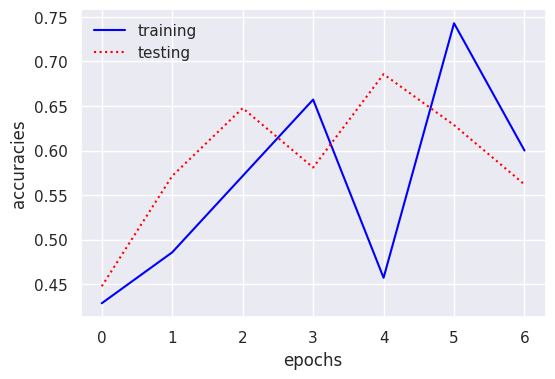

In [24]:
plt.plot(training_accuracies, color='blue', label='training')
plt.plot(testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('BC_learning.pdf')
plt.show()

#### testing

In [25]:
tmp = []
for i in range(0, len(predictions)):
    for j in range(0, len(predictions[i])):
        tmp.append(predictions[i][j])
        
accuracy_train = 1 - ( (sum(np.abs(2*y_train-1-tmp))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))

Training accuracy: 0.563265306122449


In [26]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], theta_opt, n, d, shots))

accuracy_test = 1 - ((sum(np.abs(2*y_test-1-h_test)/2)) / len(y_test) )
print('Testing accuracy: '+ str(accuracy_test))

Testing accuracy: 0.5809523809523809


### Cross-Validation

### split

In [27]:
k = 10
assert len(X)%k == 0 
ele_per_split = int(len(X)/k)

### training

In [28]:
theta = init_theta
k_thetas = []
k_training_accuracies = []
k_testing_accuracies = []

for i in tqdm(range(k)):
    
    k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)
    k_X_train, k_X_test, k_y_train, k_y_test = PCA1(k_X_train, k_X_test, k_y_train, k_y_test, n_dimensions)

    objective_function = lambda theta: MSE_loss(theta, k_X_train, k_y_train,shots)
    optimizer = SPSA(maxiter=50)
    
    k_theta_opt = optimizer.minimize(objective_function, theta).x

    k_thetas.append(k_theta_opt)

    k_train_predictions = np.zeros(len(k_y_train))
    for j in range(0, len(k_y_train)):
        k_train_predictions[j] = h(k_X_train[j], k_theta_opt, n, d, shots) 

    k_test_predictions = np.zeros(len(k_y_test))
    for j in range(0, len(k_y_test)):
        k_test_predictions[j] = h(k_X_test[j], k_theta_opt, n, d, shots) 
        
    k_train_result = 1 - ( (sum(np.abs(2*k_y_train-1-k_train_predictions))/2) / len(k_y_train) )
    k_test_result = 1 - ( (sum(np.abs(2*k_y_test-1-k_test_predictions)/2)) / len(k_y_test) )
    k_training_accuracies.append(k_train_result)
    k_testing_accuracies.append(k_test_result)

100%|██████████| 10/10 [29:48<00:00, 178.85s/it]


In [29]:
print('Training accuracies: '+ str(k_training_accuracies))
print('Training mean: '+ str(np.mean(k_training_accuracies)))
print('Testing accuracies: '+ str(k_testing_accuracies))
print('Testing mean: '+ str(np.mean(k_testing_accuracies)))

Training accuracies: [0.6698412698412699, 0.5714285714285714, 0.7206349206349206, 0.653968253968254, 0.6126984126984127, 0.6571428571428571, 0.6, 0.6412698412698412, 0.6253968253968254, 0.6571428571428571]
Training mean: 0.6409523809523809
Testing accuracies: [0.6, 0.5428571428571429, 0.6285714285714286, 0.6857142857142857, 0.5428571428571429, 0.7428571428571429, 0.48571428571428577, 0.5428571428571429, 0.5714285714285714, 0.5142857142857142]
Testing mean: 0.5857142857142857


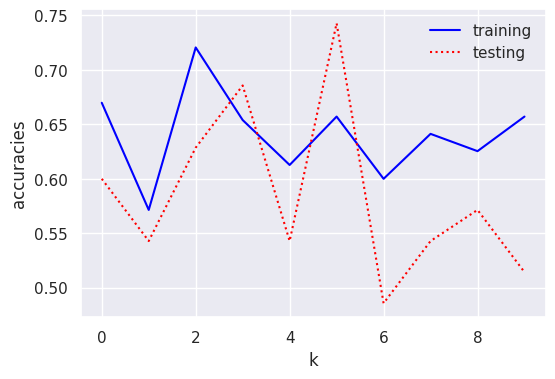

In [30]:
plt.plot(k_training_accuracies, color='blue', label='training')
plt.plot(k_testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('k')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('BC_cv.pdf')
plt.show()

### valuation

In [31]:
max_testing_accuracy = max(k_testing_accuracies)
index = k_testing_accuracies.index(max_testing_accuracy)
k_theta_opt = k_thetas[index]

dataset = load_breast_cancer()
X_val = dataset.data[:number_of_points]
y_val = dataset.target[:number_of_points]

X_val, y_val = PCA2(X_val, y_val, n_dimensions)

h_val = np.zeros(len(y_val))
for i in range(0, len(y_val)):
    h_val[i] = h(X_val[i], k_theta_opt, n, d, shots) 

validation_accuracy = 1 - ( (sum(np.abs(2*y_val-1-h_val))/2) / len(y_val) )

print("Optimal parameters: "+ str(k_theta_opt))
print("Validation accuracy: "+ str(validation_accuracy))

Optimal parameters: [ 4.32362554  6.68390183  1.65605875  2.65885714 -0.27306098 -0.25103723
  3.98578315  6.50118066  3.20952881  3.61171539 -0.36844214  6.51746336
  3.88089985  1.64834627  0.98660963  2.60864349  0.60664686  4.15370868
  3.40974711  1.06213456  2.68302428  0.97800708  4.09467762  6.83583233]
Validation accuracy: 0.5514285714285714


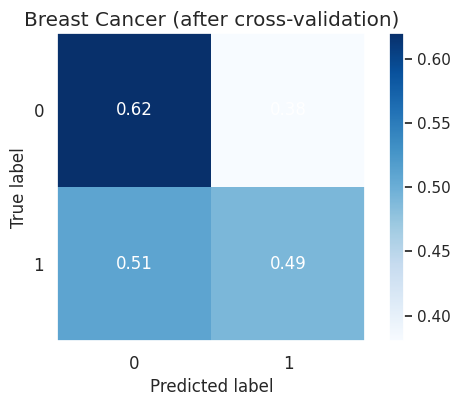

In [32]:
tmp = []
for i in range(0, len(h_val)):
    if h_val[i] == 1:
        tmp.append(1)
    else:
        tmp.append(0)
        
skplt.metrics.plot_confusion_matrix(y_val, tmp, normalize=True, title = 'Breast Cancer (after cross-validation)');
plt.savefig('BC_cf.pdf')
plt.show()